In [2]:
import tensorflow as tf
from tensorflow.keras import losses , metrics , applications ,layers  , models , callbacks , optimizers
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use("dark_background")

import os 
import shutil 
import cv2
from tqdm import tqdm
import pandas as pd
from PIL import Image , ImageEnhance
import gc
from shutil import copyfile
from pprint import pprint
# from sklearn.preprocessing import MinMaxScaler

In [3]:
def display_images(List = None,Labels = None,size = 2,cmap = 'jet',grid=None):
    try:
        if(List!=None):
            n = len(List)
            
            if(grid==None):
                grid = (1,n)
                
            plt.figure(figsize = (size * grid[1] , size*grid[0]))
            for i in range(n):
                plt.subplot(grid[0],grid[1],i+1)
                plt.imshow(List[i],cmap = cmap)
                plt.axis('off')
                if(Labels != None):
                    plt.title(Labels[i],color = 'cyan')
            plt.show()
            
    except Exception as e:
        print('Error :',e)

In [19]:
# # !mkdir .\datasets\kaggle
# os.environ['KAGGLE_USERNAME'] = 'prajwalsharma123'
# os.environ['KAGGLE_KEY']='6719f9750ed948ff6d82400eab62fe8c'

# !kaggle datasets download -d abdallahwagih/retina-blood-vessel

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


 85%|████████████████████████████████▎     | 28.0M/32.9M [00:01<00:00, 30.4MB/s]
100%|██████████████████████████████████████| 32.9M/32.9M [00:01<00:00, 22.8MB/s]


In [20]:
# import zipfile
# zip_path = 'retina-blood-vessel.zip'
# dest_path = 'datasets/'

# try:
#     shutil.rmtree(dest_path)
# except:
#     pass

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('datasets')
# os.remove(zip_path)
# # shutil.rmtree('datasets/lgg-mri-segmentation')

In [11]:
# pip install segmentation_models

In [6]:
tf.keras.backend.set_image_data_format('channels_last')
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


## Organising Data into Directory

In [7]:
train_image_path = 'datasets/Data/train/image/'
train_mask_path = 'datasets/Data/train/mask/'
test_image_path = 'datasets/Data/test/image/'
test_mask_path = 'datasets/Data/test/mask/'
sub_folder_name = 'img/'

In [8]:
# def get_image_sizes(source_path,get_uniq=False):
#     Set1 = set()
#     List = []
#     try:
#         image_paths = os.listdir(source_path)
#         for image_path in tqdm(image_paths):
#             try:
#                 s_path = source_path + image_path
#                 image = Image.open(s_path)
#                 Set1.add(np.shape(image))
                
#                 if(get_uniq):
#                     List += list(np.unique(np.array(image)))
# #                     plt.imshow(image,cmap='hot')
# #                     plt.axis('off')
# #                     plt.show()
# #                     Set2.add(np.unique(np.array(image)))
#             except Exception as e:
#                 print('Error :',e)
#                 pass
#     except Exception as e:
#         print('Source Path Error :')
        
#     if(get_uniq):
#         return Set1 ,set(List)
#     else :
#         return Set1

In [ ]:
# print(get_image_sizes(source_path = train_image_path))
# print(get_image_sizes(source_path = train_mask_path ,get_uniq=True))
# print(get_image_sizes(source_path = test_image_path))
# print(get_image_sizes(source_path = test_mask_path,get_uniq=True))

In [106]:
# def Add_dim_image(source_path):
#     Set =set()
#     try:
#         image_paths = os.listdir(source_path)
#         for image_path in tqdm(image_paths):
#             try:
#                 s_path = source_path + image_path
#                 image = Image.open(s_path)
#                 image = image.convert("RGB")
# #                 print(np.shape(image))
#                 image.save(s_path)
#             except Exception as e:
#                 print(e)

#     except Exception as e:
#         print('Source Path Error :')
#     return Set

In [107]:
# Add_dim_image(source_path = train_mask_path)
# Add_dim_image(source_path = test_mask_path)
# print(get_image_sizes(source_path = train_mask_path))
# print(get_image_sizes(source_path = test_mask_path))

### > Experimenting

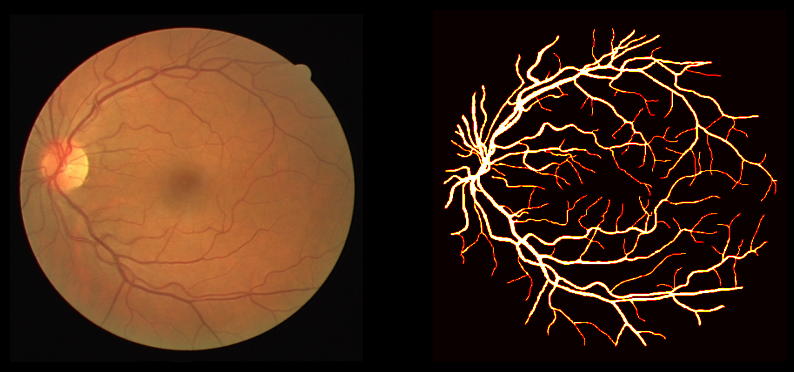

In [6]:
image = Image.open('datasets/Data/test/image/img/0.png')
mask = Image.open('datasets/Data/test/mask/img/0.png')
image = np.array(image) 
display_images([image,mask],size = 5,cmap= 'hot')

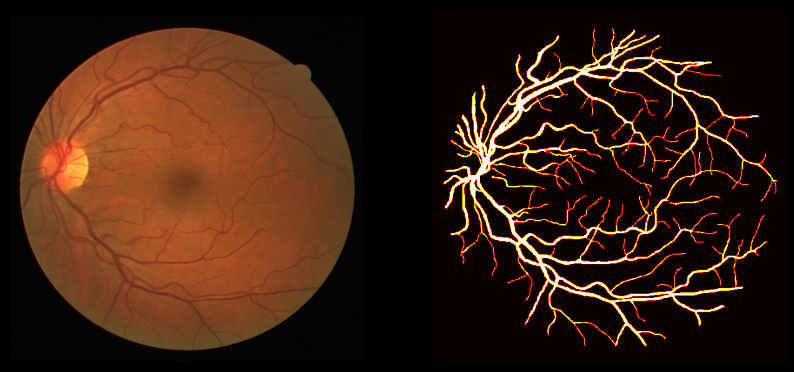

In [7]:
image_1 = np.exp(np.array(image)/255.)
img_min = image_1.min()
img_max = image_1.max()
# print(img_max)
image_1 = (image_1 - img_min) / (img_max - img_min)
display_images([image_1,mask],size = 5,cmap= 'hot')

0.0 1.0


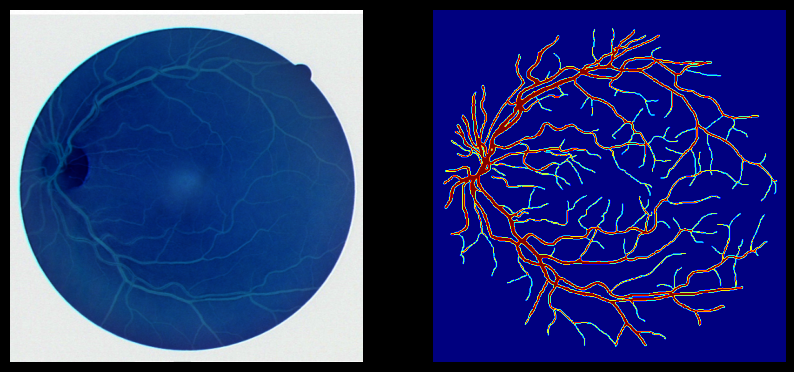

In [103]:
image_2 = np.power((255-image) ,3.,)
img_min = image_2.min()
img_max = image_2.max()
# print(img_min,img_max)
image_2 = np.array((image_2 - img_min) / (img_max - img_min),dtype='float32')
print(image_2.min(),image_2.max())
display_images([image_2 ,mask],size = 5,)

In [93]:
image_gray = np.array(Image.fromarray(255-image).convert('L'))
np.min(image_gray) , np.max(image_gray)

(32, 255)

255 32
130 0


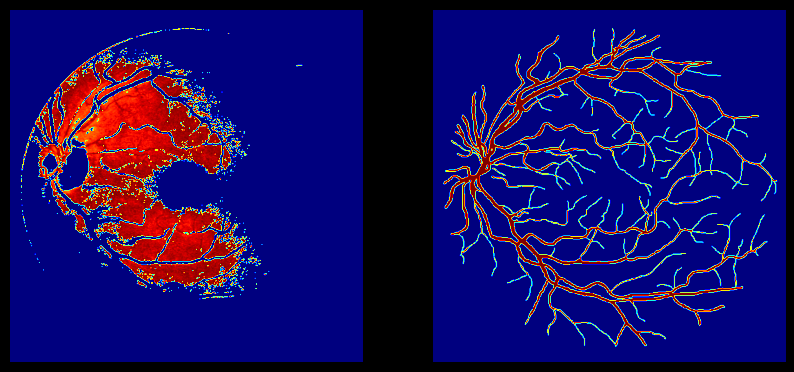

In [101]:
bound = np.array([30,60]) + 70
image_3 = image_gray.copy()
print(image_3.max(),image_3.min())

for i in range(512):
    for j in range(512):
        if(image_3[i][j] <bound[0] or image_3[i][j] > bound[1]):
            image_3[i][j]=0

print(image_3.max(),image_3.min())
image_3 = np.array(image_3,dtype = 'float32')
display_images([image_3 ,mask],size = 5)

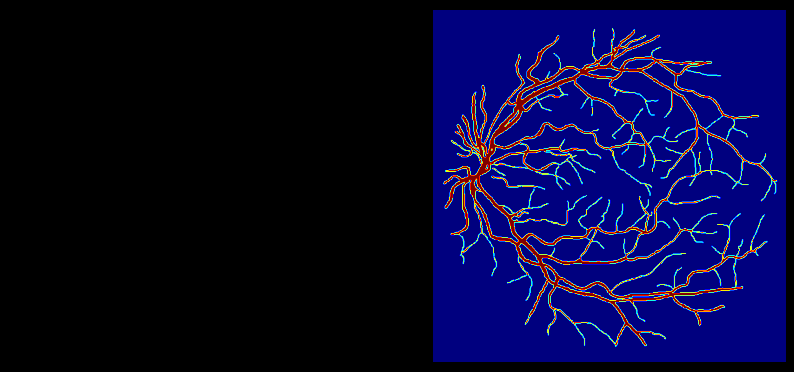

In [37]:
threshold = 0.46
image_3 = (255-image_2)/255.-threshold
image_3 = np.array((image_3 < 0.01),dtype = 'float32')
display_images([image_3 ,mask],size = 5)

### > Adding Patches to subfolder

In [12]:
# pip install patchify

In [13]:
from patchify import patchify, unpatchify

In [29]:
# patch_size = (64,64)
# step = 64

# def patch_path(d_path,num):
#     i = d_path.find('.')
#     d_path = d_path[:i]+'_'+str(num)+d_path[i:]
#     return d_path


# def Add_patches(image , dest_path):
#     image = np.array(image)

#     if(image.shape[-1]==3):
#         patches = patchify(image , patch_size + (3,) ,step = step)
#         patches = np.squeeze(patches ,axis= 2)
#     else:
#         patches = patchify(image , patch_size ,step = step)

#     patches_shape = patches.shape  
    
# #     print(patches_shape)
    
#     for i in range(patches_shape[0]):
#         for j in range(patches_shape[1]):
# #             print(patches[i][j].shape)
#             num = i*patches_shape[0] + j
#             d_path = patch_path(dest_path,num)
#             image = Image.fromarray( patches[i][j]).save(d_path)

# # Add_patches(image,"__.png")
# # Add_patches(mask,'__.png')

In [30]:
# def AddPatchesToSubfolder(source_path , subfolder_name='img/'):
#     dest_path = source_path+subfolder_name
#     image_paths = os.listdir(source_path)

#     try:
#         os.mkdir(dest_path)
#         for image_path in tqdm(image_paths):
#             try:
#                 s_path = source_path + image_path
#                 d_path = dest_path + image_path
#                 image = Image.open(s_path)
                
#                 Add_patches(image , d_path)
# #                 print(s_path,d_path)
#                 os.remove(s_path)

#             except Exception as e:
#                 print('Error : ',e,'with path :',image_path)
                
#         print(len(os.listdir(dest_path)) ,'images saved successfully')
        
#     except Exception as e:
#         print('Error : ',e)

In [31]:
# AddPatchesToSubfolder(source_path = train_image_path , subfolder_name=sub_folder_name)
# AddPatchesToSubfolder(source_path = train_mask_path , subfolder_name=sub_folder_name)
# # # AddPatchesToSubfolder(source_path = test_image_path , subfolder_name=sub_folder_name)
# # AddPatchesToSubfolder(source_path = test_mask_path , subfolder_name=sub_folder_name)

100%|██████████| 80/80 [00:12<00:00,  6.41it/s]


5120 images saved successfully


100%|██████████| 80/80 [00:02<00:00, 35.41it/s]

5120 images saved successfully


### > Add Images to sub folder

In [31]:
# def AddToSubfolder(source_path , subfolder_name='img/'):
#     dest_path = source_path+subfolder_name
#     image_paths = os.listdir(source_path)

#     try:
#         os.mkdir(dest_path)
#         for image_path in tqdm(image_paths):
#             try:
#                 s_path = source_path + image_path
#                 d_path = dest_path + image_path
#                 copyfile(s_path,d_path)
#     #                 print(s_path,d_path)
#                 os.remove(s_path)

#             except Exception as e:
#                 print('Error : ',e,'with path :',image_path)
#         print(len(os.listdir(dest_path)) ,'images saved successfully')
#     except Exception as e:
#         print('Error : ',e)

In [32]:
# # AddToSubfolder(source_path = train_image_path , subfolder_name=sub_folder_name)
# # AddToSubfolder(source_path = train_mask_path , subfolder_name=sub_folder_name)
# AddToSubfolder(source_path = test_image_path , subfolder_name=sub_folder_name)
# AddToSubfolder(source_path = test_mask_path , subfolder_name=sub_folder_name)

100%|██████████| 20/20 [00:00<00:00, 2107.43it/s]


20 images saved successfully


100%|██████████| 20/20 [00:00<00:00, 3830.59it/s]

20 images saved successfully


## > Data Generator PipeLine 

In [14]:
sharpness = 15
contrast = 1.0

def adjust_sharpness(image):
    image = np.array(image,dtype = np.uint8)
    image = ImageEnhance.Sharpness(Image.fromarray(image)).enhance(sharpness)  # Increase saturation (adjust as needed)
    return image

# Define a function to adjust contrast
def adjust_contrast(image):
    image = np.array(image , dtype = np.uint8)
    image = ImageEnhance.Contrast(Image.fromarray(image)).enhance(contrast)  # Increase contrast (adjust as needed)
    return image

def preprocess_image(image):
    
    image = np.array(image,dtype = np.uint8)
    
    image = adjust_sharpness(image)
    image = adjust_contrast(image)
    
    image = sm.get_preprocessing(back_bone)(np.array(image,dtype = 'float32'))
    return image

In [15]:
def min_max_scaler(image):
    
    image = adjust_sharpness(image)
    image = adjust_contrast(image)
    
    ## Scaling 
#     image = np.array(image , dtype = 'float32')
    
#     img_min = np.min(image)
#     img_max = np.max(image)
    
#     image = (image - img_min) / (img_max - img_min)
    image = np.array(image , dtype = 'float32')/255.0
    return image

In [121]:
back_bone = 'efficientnetb0'
# back_bone = 'vgg16'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Define data augmentation parameters

seed = 42 


image_gen_args = dict(
#     rotation_range = 180,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    
    fill_mode='constant',
    cval=0,
    
    validation_split=0.1,
#     rescale = 1./255,
#     preprocessing_function = min_max_scaler,
#     preprocessing_function  = sm.get_preprocessing(back_bone),
    preprocessing_function  = preprocess_image,
    
)  # You might need to adjust these parameters


# def mask_reval(mask):
#     mask = np.where(mask>0 ,1,0).astype(mask.dtype)# 3 Channels 
#     return mask

mask_gen_args = dict(
#     rotation_range = 180,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    
    fill_mode='constant',
    cval=0,
    
    validation_split=0.1,
#     preprocessing_function = mask_reval,
    preprocessing_function = lambda x:np.where(x>0 ,1,0).astype(x.dtype),
#     preprocessing_function =lambda x:np.expand_dims( np.where(x>0 ,1,0).astype(x.dtype) , axis = -1) ,
) 

# Create ImageDataGenerator instances for image and mask data
image_datagen = ImageDataGenerator(**image_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

In [122]:
batch_size = 16
# image_shape = (512,512)
image_shape = (64,64)

# Flow data from directories
train_image_generator = image_datagen.flow_from_directory(
    train_image_path,
    class_mode= None,
    color_mode ='rgb',
    batch_size = batch_size,
    seed=seed,
    subset='training',
    target_size=image_shape,
)

# Flow data from directories
val_image_generator = image_datagen.flow_from_directory(
    train_image_path,
    class_mode=None,
    color_mode ='rgb',
    batch_size = batch_size,
    seed=seed,
    subset='validation',
    shuffle=False,
    target_size=image_shape,
)

train_mask_generator = mask_datagen.flow_from_directory(
    train_mask_path ,
    class_mode=None,
    color_mode ='grayscale',
    batch_size = batch_size,
    seed=seed,
    subset='training',
    target_size=image_shape,
)

val_mask_generator = mask_datagen.flow_from_directory(
    train_mask_path ,
    class_mode=None,
    color_mode = 'grayscale',
    batch_size = batch_size,
    seed=seed,
    subset='validation',
    shuffle=False,
    target_size=image_shape,
)

Found 4608 images belonging to 1 classes.
Found 512 images belonging to 1 classes.
Found 4608 images belonging to 1 classes.
Found 512 images belonging to 1 classes.


In [123]:
# batch_size = 2
image_shape = (512,512)
# image_shape = (64,64)

image_gen_args = dict(
#     zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function  = sm.get_preprocessing(back_bone),
#     preprocessing_function  = preprocess_image,
#     preprocessing_function = min_max_scaler,
)  # You might need to adjust these parameters

mask_gen_args = dict(
#     zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function =lambda x:np.where(x>0 ,1,0).astype(x.dtype),
) 

image_datagen = ImageDataGenerator( **image_gen_args )
mask_datagen = ImageDataGenerator( **mask_gen_args )

# Flow data from directories
test_image_generator = image_datagen.flow_from_directory(
    test_image_path,
    class_mode = None,
    color_mode ='rgb',
    batch_size = batch_size,
    seed=seed,
    target_size = image_shape,
    shuffle = False,
    
)

test_mask_generator = mask_datagen.flow_from_directory(
    test_mask_path ,
    class_mode=None,
    color_mode ='grayscale',
    batch_size = batch_size,
    seed=seed,
    target_size=image_shape,
    shuffle=False,
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [124]:
def get_my_generator(image_generator ,mask_generator):
    data_generator = zip(image_generator ,mask_generator)
    for images , masks in data_generator:
        images = np.array(layers.UpSampling2D((2,2))(images))
        masks = np.array(layers.UpSampling2D((2,2))(masks))
        yield(images,masks)
        
# Combine generators into one which yields image and masks
train_generator = get_my_generator(train_image_generator, train_mask_generator)
val_generator = get_my_generator(val_image_generator, val_mask_generator)
test_generator = get_my_generator(test_image_generator, test_mask_generator)
train_generator

<generator object get_my_generator at 0x7dbce8601b60>

In [114]:
images,masks = next(iter(train_generator))
images.shape ,masks.shape

((16, 128, 128, 3), (16, 128, 128, 1))

-2.0357141 1.5639181


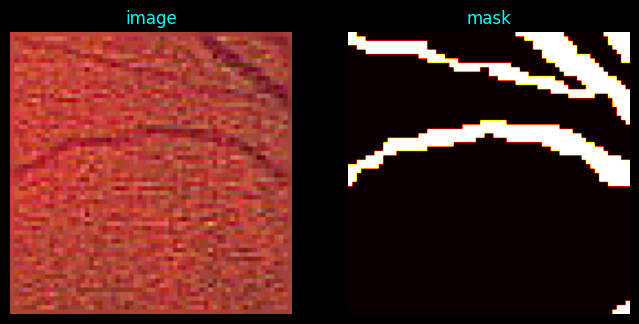

-2.117904 2.4285715


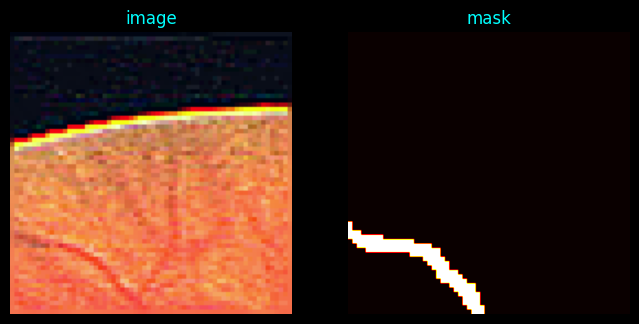

-2.117904 0.7590547


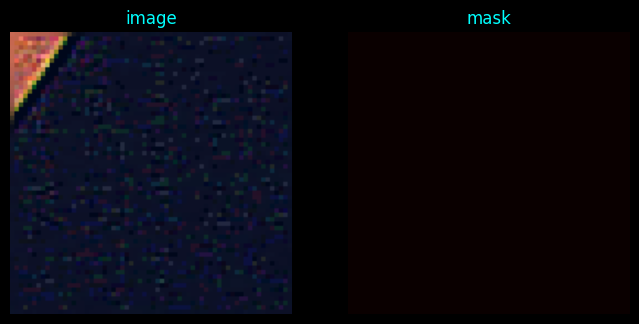

-2.117904 2.64


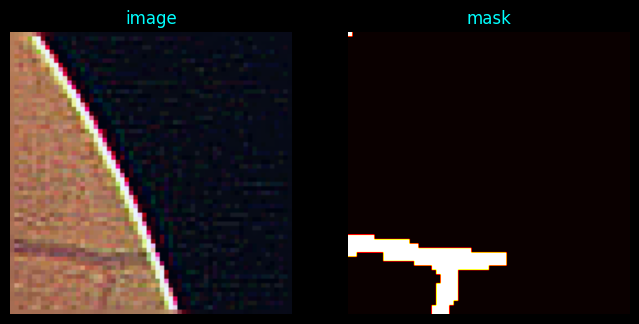

-1.8781512 2.2489083


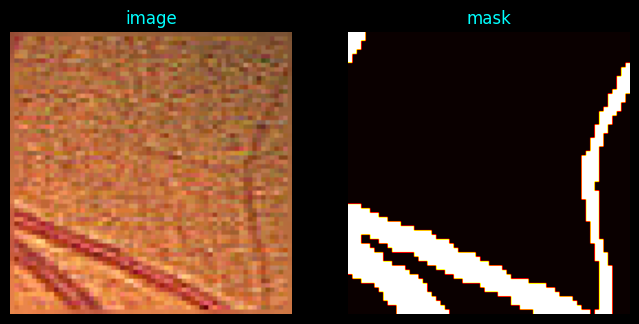

-2.117904 -1.1421349


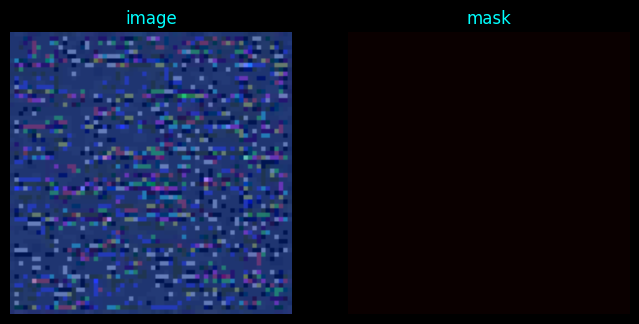

-2.117904 2.64


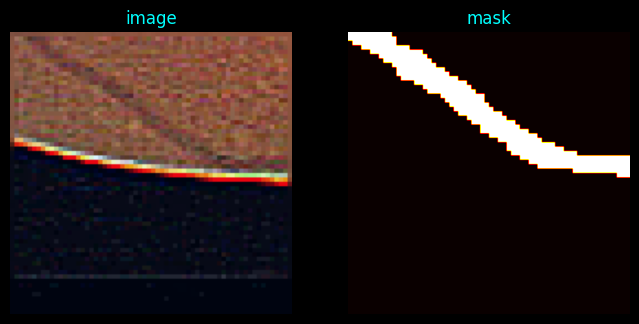

-2.117904 2.1804092


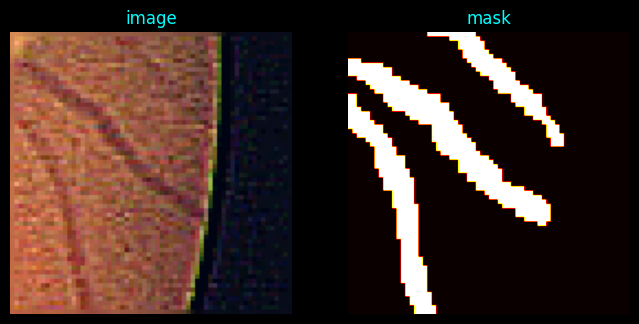

-1.8044444 2.2489083


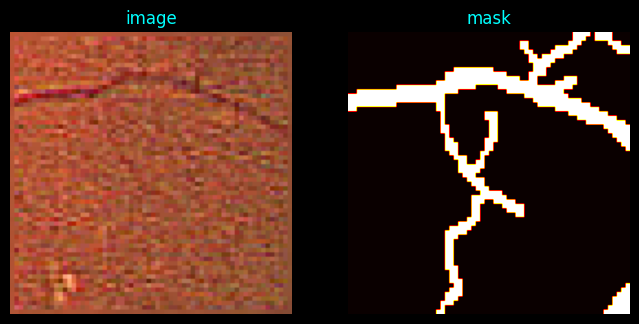

-2.0357141 2.4285715


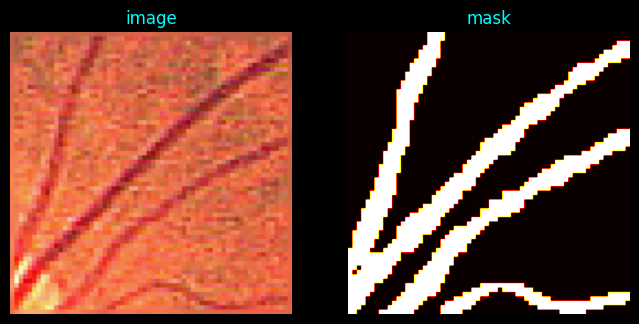

-2.117904 2.64


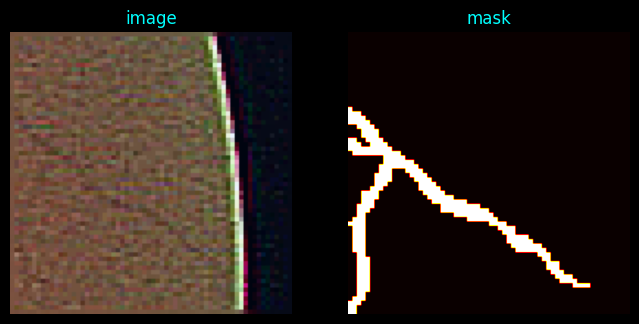

-2.117904 2.64


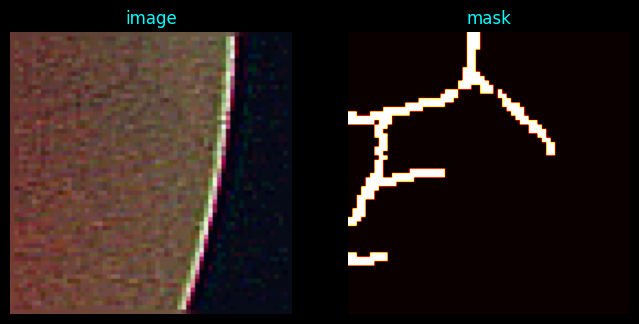

-2.0357141 1.6495419


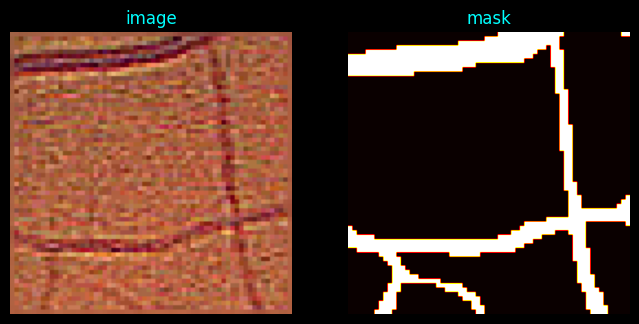

-1.6301525 2.2317834


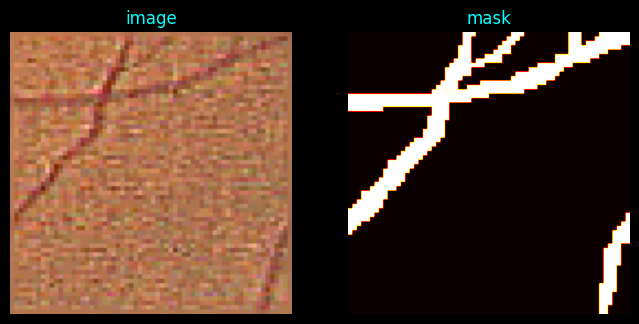

-2.117904 2.64


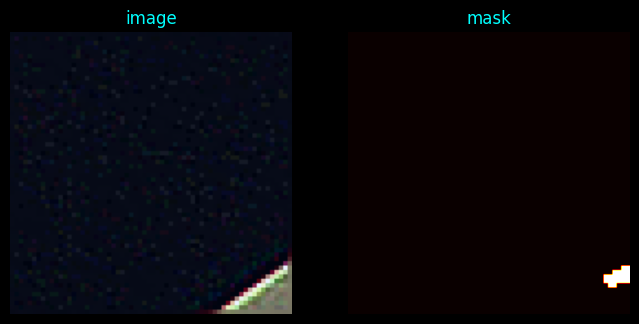

-1.9656862 2.2489083


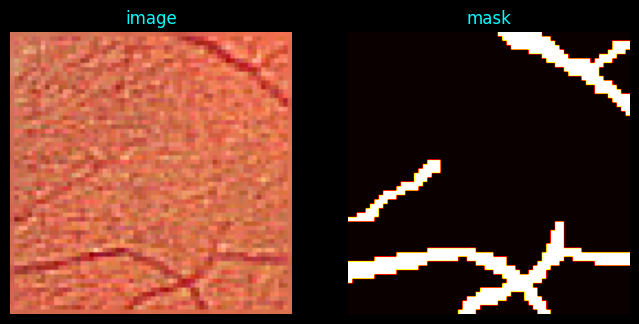

In [115]:
for image , mask in zip(images , masks):
    img_min , img_max = np.min(image) , np.max(image)
    print(img_min , img_max)
    image = (image-img_min) / (img_max-img_min) 
    display_images([image ,mask],['image','mask'],size = 4,cmap='hot')

## > Loading Model

### > Pretrainined Model

In [41]:
# back_bone - 'vgg16'
back_bone = 'efficientnetb0'
image_shape = (128,128,3)
Model = sm.Unet( backbone_name=back_bone,
                encoder_weights='imagenet',
                input_shape = image_shape,
                classes=1,
                activation = 'sigmoid',
                encoder_freeze=True,
#                 decoder_filters=(256, 128, 64, 32, 16,8),
                decoder_block_type ='transpose',
                   )
Model.summary(line_length=100)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 128, 128, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_conv (Conv2D)          │ (None, 64, 64, 32)      │            864 │ input_layer_1[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_bn                     │ (None, 64, 64, 32)      │            128 │ stem_conv[0][0]         │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_activation             │ (None, 64, 64, 32)      │              0 │ stem_bn[0][0]           │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_dwconv              │ (None, 64, 64, 32)      │            288 │ stem_activation[0][0]   │
│ (DepthwiseConv2D)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_bn                  │ (None, 64, 64, 32)      │            128 │ block1a_dwconv[0][0]    │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_activation          │ (None, 64, 64, 32)      │              0 │ block1a_bn[0][0]        │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_squeeze          │ (None, 32)              │              0 │ block1a_activation[0][… │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_reshape          │ (None, 1, 1, 32)        │              0 │ block1a_se_squeeze[0][… │
│ (Reshape)                   │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_reduce (Conv2D)  │ (None, 1, 1, 8)         │            264 │ block1a_se_reshape[0][… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_expand (Conv2D)  │ (None, 1, 1, 32)        │            288 │ block1a_se_reduce[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_excite           │ (None, 64, 64, 32)      │              0 │ block1a_activation[0][… │
│ (Multiply)                  │                         │                │ block1a_se_expand[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_project_conv        │ (None, 64, 64, 16)      │            512 │ block1a_se_excite[0][0] │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_project_bn          │ (None, 64, 64, 16)      │             64 │ block1a_project_conv[0… │
│ (BatchNormalization)        │                         │    

 Total params: 12,713,901 (48.50 MB)

 Trainable params: 8,704,369 (33.20 MB)

 Non-trainable params: 4,009,532 (15.30 MB)

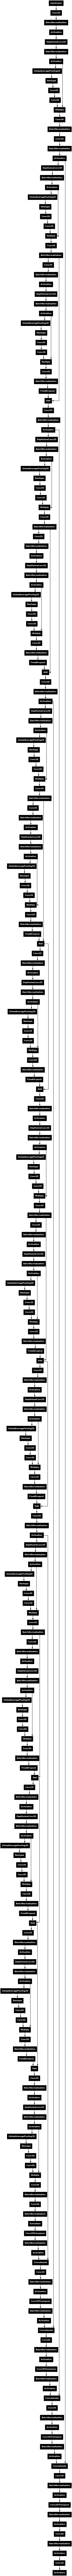

In [40]:
# tf.keras.utils.plot_model(Model)

In [97]:
# for layer in Model.layers:
#     layer.trainable=True
# Model.summary(line_length=100)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 128, 128, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_conv (Conv2D)          │ (None, 64, 64, 32)      │            864 │ input_layer_1[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_bn                     │ (None, 64, 64, 32)      │            128 │ stem_conv[0][0]         │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_activation             │ (None, 64, 64, 32)      │              0 │ stem_bn[0][0]           │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_dwconv              │ (None, 64, 64, 32)      │            288 │ stem_activation[0][0]   │
│ (DepthwiseConv2D)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_bn                  │ (None, 64, 64, 32)      │            128 │ block1a_dwconv[0][0]    │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_activation          │ (None, 64, 64, 32)      │              0 │ block1a_bn[0][0]        │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_squeeze          │ (None, 32)              │              0 │ block1a_activation[0][… │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_reshape          │ (None, 1, 1, 32)        │              0 │ block1a_se_squeeze[0][… │
│ (Reshape)                   │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_reduce (Conv2D)  │ (None, 1, 1, 8)         │            264 │ block1a_se_reshape[0][… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_expand (Conv2D)  │ (None, 1, 1, 32)        │            288 │ block1a_se_reduce[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_excite           │ (None, 64, 64, 32)      │              0 │ block1a_activation[0][… │
│ (Multiply)                  │                         │                │ block1a_se_expand[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_project_conv        │ (None, 64, 64, 16)      │            512 │ block1a_se_excite[0][0] │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_project_bn          │ (None, 64, 64, 16)      │             64 │ block1a_project_conv[0… │
│ (BatchNormalization)        │                         │    

 Total params: 12,713,901 (48.50 MB)

 Trainable params: 12,669,901 (48.33 MB)

 Non-trainable params: 44,000 (171.88 KB)

### > Model From Scratch

In [41]:
General_Config = {
    'image_shape' : (512,512),
    'n_channel' : 3,
    'n_class' : 1,
}

Model_Config = {
    'n_level' : 4,
    'n_unit' : 32, ## start Units  
    'scaling_factor' : 2,
    'kernel_size' : 3,
    'n_block_layer' : 2, ## Number of layers in Each Block ..
    'activation' : 'relu',
    'strides':1,
}

In [20]:
def ConvBlock(x ,n_unit):
    x = layers.Conv2D(n_unit, Model_Config['kernel_size'],strides = Model_Config['strides'],padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def Simple_Block(x_input ,n_unit = 64):
    x_input = layers.Conv2D(n_unit,1, strides = 1,padding='same',activation = 'relu')(x_input)

    n_layer = Model_Config['n_block_layer']
    x_out = x_input 
    
    for j in range(n_layer):     
        x_out = ConvBlock(x_out,n_unit)

    return x_out

def Residual_Block( x_input ,n_unit = 64):
    x_input = layers.Conv2D(n_unit,1, strides = 1,padding='same',activation = 'relu')(x_input)

    n_layer = Model_Config['n_block_layer']
    x_out = x_input 
    
    for j in range(n_layer):     
        x_out = ConvBlock(x_out,n_unit)
    
    x_add = layers.Add()([x_out ,x_input])
    x_out = ConvBlock(x_add,n_unit)
    return x_out

time = 2
def Recurrent_Block( x_input ,n_unit = 64):
    x_input = layers.Conv2D(n_unit,1, strides = 1,padding='same',activation = 'relu')(x_input)

    n_layer = Model_Config['n_block_layer']
    x_out = x_input 
    
    for j in range(n_layer):      ## time is same as n_layer.
        x_res = ConvBlock(x_out,n_unit)
        
        for _ in range(time):            
            x_add = layers.Add()([x_out,x_res])
            x_res = ConvBlock(x_add,n_unit)
            
        x_out = x_res  ## save value to x to use in next iteration..

    return x_out

time = 2
def R2_Block( x_input ,n_unit = 64):
    x_input = layers.Conv2D(n_unit,1, strides = 1,padding='same',activation = 'relu')(x_input)

    n_layer = Model_Config['n_block_layer']
    x_out = x_input 
    
    for j in range(n_layer):      ## time is same as n_layer.
        x_res = ConvBlock(x_out,n_unit)
        
        for _ in range(time):            
            x_add = layers.Add()([x_out,x_res])
            x_res = ConvBlock(x_add,n_unit)
            
        x_out = x_res  ## save value to x to use in next iteration..

    x_add = layers.Add()([x_out ,x_input])
    x_out = ConvBlock(x_add,n_unit)
    return x_out

def Unit_Block(x_input ,n_unit = 64,num = 0):
    if(num==0):
        x_output = Simple_Block(x_input,n_unit) 
    elif(num==1):
        x_output = Residual_Block(x_input,n_unit) 
    elif(num==2):
        x_output = Recurrent_Block(x_input,n_unit) 
    else:
        x_output = R2_Block(x_input,n_unit) 
    return x_output;
        

In [22]:
def Decoder_Block1(x,y):
    scale = Model_Config['scaling_factor']
    x = layers.UpSampling2D(scale)(x)
    x = layers.Concatenate()([x,y])
    return x

def Decoder_Block2(x,y,n_unit):  ## with transpose
    scale = Model_Config['scaling_factor']
    x = layers.Conv2DTranspose(n_unit ,scale ,strides = scale ,activation = 'relu')(x)
    x = layers.Concatenate()([x,y])
    return x


def Decoder_Block3(x,y_skip,n_unit): ## With attenction
    scale = Model_Config['scaling_factor']
    
    y = layers.Conv2D(n_unit,1,strides = scale, padding='same', activation = 'relu')(y_skip)
    x = layers.Conv2D(n_unit,1,strides = 1, padding='same', activation = 'relu')(x)
    y = layers.Add()([x,y])
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2D(1 ,1,padding='same',strides = 1)(y)
    
#     y = layers.Conv2DTranspose(1,scale ,scale ,activation = 'sigmoid')(y)
    y = layers.UpSampling2D(scale)(y)
    y = layers.Activation('tanh')(y)

    y = layers.Multiply()([y,y_skip])
    y = layers.Activation('relu')(y)
    return y


In [23]:
def Encode(x,num):
    scale = Model_Config['scaling_factor']
    n_level = Model_Config['n_level']
    n_unit = Model_Config['n_unit']
    
    Encoder_List = []
    for i in range(n_level):
        x = Unit_Block(x,n_unit,num)

        Encoder_List.append(x)
        x = layers.MaxPool2D(scale,scale)(x)
        n_unit *= scale
    return x , Encoder_List , n_unit

def Decode(x,Encoder_List , n_unit,num):
    scale = Model_Config['scaling_factor']
    n_level = Model_Config['n_level']
    
    for i in range(n_level):
        n_unit = n_unit//scale
        y = Encoder_List.pop()
        x = Decoder_Block1(x,y)
#         x = Decoder_Block2(x,y,n_unit)
#         x = Decoder_Block3(x,y,n_unit)
        x = Unit_Block(x,n_unit,num)
    return x

In [24]:
def BuildUnet(backbone=None , num = 0):
    image_shape = General_Config['image_shape']+(General_Config['n_channel'],)
    n_class = General_Config['n_class']
    
    fn_input = layers.Input(shape = image_shape)
    ## Encoding ..............................
    x_enc , Encoder_List ,n_unit = Encode(fn_input , num )
#     if(backbone):
#         x , Encoder_List , n_unit = Encode2(fn_input,image_shape,backbone)
#     else :
#         x , Encoder_List , n_unit = Encode(fn_input)
        
    ## Base Part ............................
    x_base = Unit_Block(x_enc,n_unit , num)
    ## Decoder Part..........................
    x_dec = Decode(x_base,Encoder_List,n_unit ,num)
    ## Ending Part ..........................
    
    fn_output = layers.Conv2D(1 ,Model_Config['kernel_size'] ,padding = 'same')(x_dec)
    if(n_class==1):
        fn_output = layers.Activation('sigmoid')(fn_output)
    else:
        fn_output = layers.Activation('softmax')(fn_output)
        
    ### Build Model ==================================================|
    Model = models.Model(fn_input ,fn_output,name = 'Unet_Model')
    return Model

In [25]:
Model = BuildUnet(num = 2)
Model.summary(line_length=100)

Model: "Unet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 512, 512, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d (Conv2D)             │ (None, 512, 512, 32)    │            128 │ input_layer[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_1 (Conv2D)           │ (None, 512, 512, 32)    │          9,248 │ conv2d[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization         │ (None, 512, 512, 32)    │            128 │ conv2d_1[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation (Activation)     │ (None, 512, 512, 32)    │              0 │ batch_normalization[0]… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ add (Add)                   │ (None, 512, 512, 32)    │              0 │ conv2d[0][0],           │
│                             │                         │                │ activation[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_2 (Conv2D)           │ (None, 512, 512, 32)    │          9,248 │ add[0][0]               │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_1       │ (None, 512, 512, 32)    │            128 │ conv2d_2[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_1 (Activation)   │ (None, 512, 512, 32)    │              0 │ batch_normalization_1[… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ add_1 (Add)                 │ (None, 512, 512, 32)    │              0 │ conv2d[0][0],           │
│                             │                         │                │ activation_1[0][0]      │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_3 (Conv2D)           │ (None, 512, 512, 32)    │          9,248 │ add_1[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_2       │ (None, 512, 512, 32)    │            128 │ conv2d_3[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_2 (Activation)   │ (None, 512, 512, 32)    │              0 │ batch_normalization_2[… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_4 (Conv2D)           │ (None, 512, 512, 32)    │          9,248 │ activation_2[0][0]      │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ batch_normalization_3       │ (None, 512, 512, 32)    │            128 │ conv2d_4[0][0]          │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ activation_3 (Activation)   │ (None, 512, 512, 32)    │    

 Total params: 24,037,313 (91.70 MB)

 Trainable params: 24,019,649 (91.63 MB)

 Non-trainable params: 17,664 (69.00 KB)

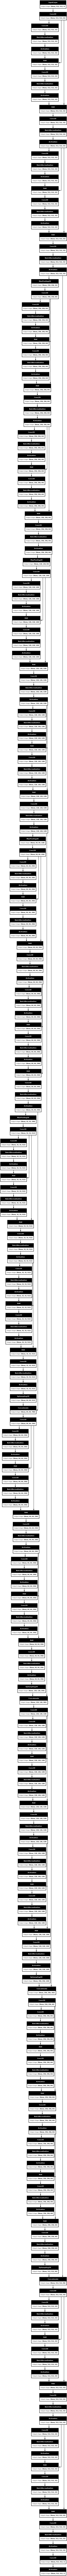

In [26]:
model_file_path = 'model_artitechture.png'
tf.keras.utils.plot_model(Model,show_shapes=True,to_file=model_file_path)

## > Training Model

In [23]:
model_weights_path1 = 'seg_model_best1.weights.h5'
model_weights_path2 = 'seg_model_best2.weights.h5'
model_weights_path3 = 'seg_model_best3.weights.h5'
model_weights_path4 = 'seg_model_best4.weights.h5'
model_weights_path5 = 'seg_model_best5.weights.h5'
model_weights_path6 = 'seg_model_best6.weights.h5'
model_weights_path7 = 'seg_model_best7.weights.h5'
model_weights_path8 = 'seg_model_best8.weights.h5'
model_weights_path9 = 'seg_model_best9.weights.h5'
model_weights_path10 = 'seg_model_best10.weights.h5'


checkpoint_callback = callbacks.ModelCheckpoint(  ## To save Best Models
    model_weights_path1,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True, ## will save best weights. 
    save_weights_only = True, ## If false will save whole model .. .
    mode = 'auto', # if monitor val_loss that it will be min else if val_accuracy that it will be Max..
    save_freq = 'epoch', ## we will do this after every epoch .
)

plateau_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, ## reduce by this factor . ## lr = lr*0.1
    patience=3, ## wait till these number of epochs ,
    verbose=1,
    mode='auto', ## similar to what studied above,,i..e Min or Max..
    min_delta=0.0, ## if change is less than delta than we will consider it as no improvement . 
    cooldown=0,  ## to wait after we have updated our lr ,,
    min_lr=0, ## dont go below this lr.
)

In [24]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
bce_loss = sm.losses.BinaryCELoss()
jaccard_loss = sm.losses.JaccardLoss()
hybrid_loss1 = dice_loss + 1.*(focal_loss)
hybrid_loss2 = dice_loss + 1.*(bce_loss) + 1.*jaccard_loss
hybrid_loss3 = jaccard_loss + bce_loss

In [118]:
# loss = dice_loss
# loss = hybrid_loss1
# loss = bce_loss
# loss = focal_loss
loss = jaccard_loss
# loss = hybrid_loss3
metrics_ = [metrics.MeanIoU(num_classes=2 , name = 'iou_score') ,'accuracy', sm.metrics.FScore(name = 'f1score'),metrics.AUC(name = 'auc',),sm.metrics.IOUScore()]
lr = 0.001
Model.compile(
    optimizer = optimizers.Adam(learning_rate=lr),
    loss = loss,
    metrics = metrics_,
)

In [99]:
History = {}
def AddToHistory(history):
    for metric,values  in history.history.items():
        if(metric not in History.keys()):
            History[metric] = []
        History[metric] += values

In [107]:
history = Model.fit(train_generator ,
            validation_data=val_generator,
            callbacks=([checkpoint_callback , 
                        plateau_callback,
#                        lr_schedular,
                       ]
                    ),
#              batch_size = 24,
            validation_steps = val_image_generator.n//batch_size,
            epochs = 20,
            steps_per_epoch= train_image_generator.n//batch_size,
            )
AddToHistory(history)

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9605 - auc: 0.9191 - f1score: 0.8365 - iou_score: 0.7883 - loss: 0.2804
Epoch 1: val_loss improved from 0.33926 to 0.33199, saving model to seg_model_best1.weights.h5
288/288 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - accuracy: 0.9605 - auc: 0.9191 - f1score: 0.8365 - iou_score: 0.7881 - loss: 0.2804 - val_accuracy: 0.9516 - val_auc: 0.8630 - val_f1score: 0.7952 - val_iou_score: 0.7513 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9597 - auc: 0.9158 - f1score: 0.8333 - iou_score: 0.7863 - loss: 0.2829
Epoch 2: val_loss improved from 0.33199 to 0.33042, saving model to seg_model_best1.weights.h5
288/288 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step - accuracy: 0.9597 - auc: 0.9158 - f1score: 0.8333 - iou_score: 0.7862 - loss: 0.2829 - val_accuracy: 0.9519 - val_auc: 0.8827 - val_f1score: 0.7853 - val_iou_score: 0.7872 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 3/20
288

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: Exception encountered when calling UpSampling2D.call().

[1m{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 1 values, but the requested shape has 393216 [Op:Reshape][0m

Arguments received by UpSampling2D.call():
  • inputs=tf.Tensor(shape=(16, 64, 64, 1), dtype=float32)
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 85, in get_tf_iterator
    for batch in self.generator:

  File "/tmp/ipykernel_34/1005297754.py", line 5, in get_my_generator
    masks = np.array(layers.UpSampling2D((2,2))(masks))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 123, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: Exception encountered when calling UpSampling2D.call().

[1m{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 1 values, but the requested shape has 393216 [Op:Reshape][0m

Arguments received by UpSampling2D.call():
  • inputs=tf.Tensor(shape=(16, 64, 64, 1), dtype=float32)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  InvalidArgumentError: Exception encountered when calling UpSampling2D.call().

[1m{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 1 values, but the requested shape has 393216 [Op:Reshape][0m

Arguments received by UpSampling2D.call():
  • inputs=tf.Tensor(shape=(16, 64, 64, 1), dtype=float32)
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 85, in get_tf_iterator
    for batch in self.generator:

  File "/tmp/ipykernel_34/1005297754.py", line 5, in get_my_generator
    masks = np.array(layers.UpSampling2D((2,2))(masks))

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 123, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: Exception encountered when calling UpSampling2D.call().

[1m{{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 1 values, but the requested shape has 393216 [Op:Reshape][0m

Arguments received by UpSampling2D.call():
  • inputs=tf.Tensor(shape=(16, 64, 64, 1), dtype=float32)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_1796273]

## > Comapring Results 

In [48]:
History

{'accuracy': [0.9171273112297058,
  0.9516724348068237,
  0.9521316885948181,
  0.951792299747467,
  0.9516317844390869,
  0.9456354975700378,
  0.9486985802650452,
  0.9506259560585022,
  0.9494838714599609,
  0.9495938420295715,
  0.950308084487915,
  0.9521669745445251,
  0.950494110584259,
  0.9529392719268799,
  0.9530608654022217],
 'auc': [0.9015940427780151,
  0.9117852449417114,
  0.907508909702301,
  0.9051381945610046,
  0.9026753902435303,
  0.8873341083526611,
  0.8948861956596375,
  0.8977958559989929,
  0.8952527642250061,
  0.895718514919281,
  0.8960097432136536,
  0.9005395174026489,
  0.8969359993934631,
  0.9024003148078918,
  0.9019860625267029],
 'f1score': [0.6936966776847839,
  0.7931738495826721,
  0.7952821254730225,
  0.7968682050704956,
  0.795207142829895,
  0.7732328772544861,
  0.7873613834381104,
  0.7931829690933228,
  0.7899733781814575,
  0.790503740310669,
  0.7923653721809387,
  0.7975232601165771,
  0.7948651909828186,
  0.8016694784164429,
  0.799

In [125]:
pprint(Model.evaluate(val_generator,steps = val_image_generator.n//batch_size,return_dict=True))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9641 - auc: 0.9346 - f1score: 0.8521 - iou_score: 0.8513 - iou_score_1: 0.7439 - loss: 0.2561
{'accuracy': 0.9583674669265747,
 'auc': 0.9155263304710388,
 'f1score': 0.8407680988311768,
 'iou_score': 0.8307523727416992,
 'iou_score_1': 0.7273175120353699,
 'loss': 0.27268242835998535}


In [126]:
pprint(Model.evaluate(train_generator,steps = train_image_generator.n//batch_size,return_dict=True))

288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9604 - auc: 0.9355 - f1score: 0.8437 - iou_score: 0.8257 - iou_score_1: 0.7301 - loss: 0.2699
{'accuracy': 0.9605979919433594,
 'auc': 0.9357814192771912,
 'f1score': 0.8432164192199707,
 'iou_score': 0.7945238947868347,
 'iou_score_1': 0.7294166088104248,
 'loss': 0.27058354020118713}


In [51]:
# pprint(Model.evaluate(test_generator,steps = test_image_generator.n//batch_size,return_dict=True))

In [59]:
Model.load_weights(model_weights_path1)

In [52]:
Model.save_weights(model_weights_path3)

# ## path 2 for efficient net

In [26]:
# Model.save('datasets/vgg_unet.keras')
# Model = models.load_model('datasets/vgg_unet.keras',compile = False)

In [27]:
# Model.summary()

## > Visualising Results 

In [84]:
def get_pred_mask(image):
    return Model.predict(tf.expand_dims(image,axis=0),verbose=0)[0]

In [85]:
# threshold = 0.5
# for image , mask in zip(images , masks):
# #     print(image.min() ,image.max() , mask.min() ,mask.max())
#     mask_pred = Model.predict(tf.expand_dims(image,axis=0))[0]
#     mask_pred = (mask_pred>threshold)
#     image = (image-image.min()) / (image.max()-image.min()) 
#     display_images([image ,mask,mask_pred],['image','mask','mask_pred'],size = 3)

In [86]:
def get_aug_image(image):
    mask_pred_1 = get_pred_mask(image)
    
    mask_pred_2 = get_pred_mask(np.fliplr(image))
    mask_pred_2 = np.fliplr(mask_pred_2)
    
    mask_pred_3 = get_pred_mask(np.flipud(image))
    mask_pred_3 = np.flipud(mask_pred_3)
    
    mask_pred_4 = get_pred_mask(np.flipud(np.fliplr(image)))
    mask_pred_4 = np.flipud(np.fliplr(mask_pred_4))
    
    mask_pred_aug = (mask_pred_1 + mask_pred_2 + mask_pred_3 + mask_pred_4)/4
    return mask_pred_1 ,mask_pred_aug

In [95]:
images,masks = next(iter(val_generator))
images.shape ,masks.shape

((16, 128, 128, 3), (16, 128, 128, 1))

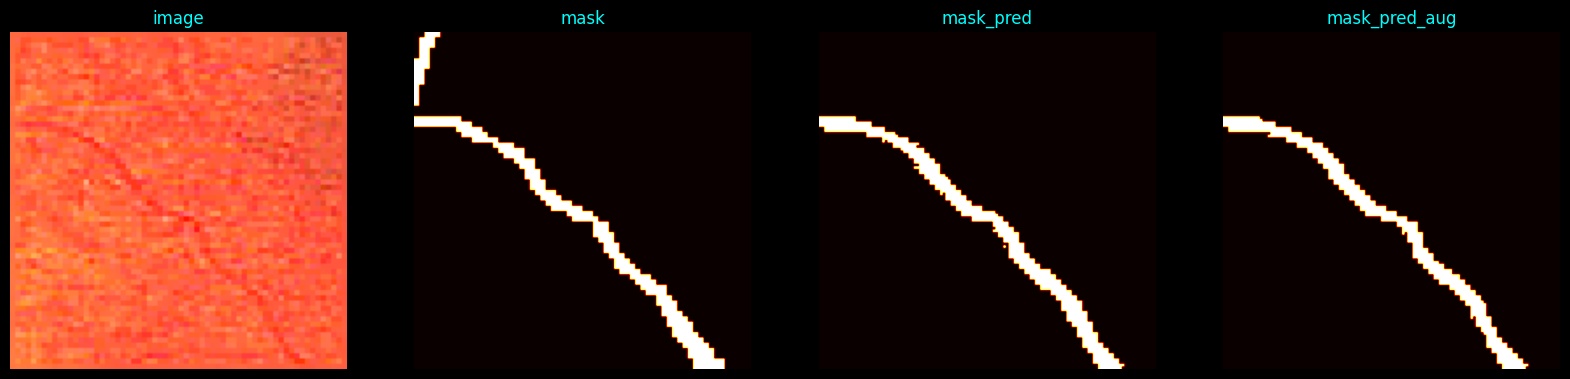

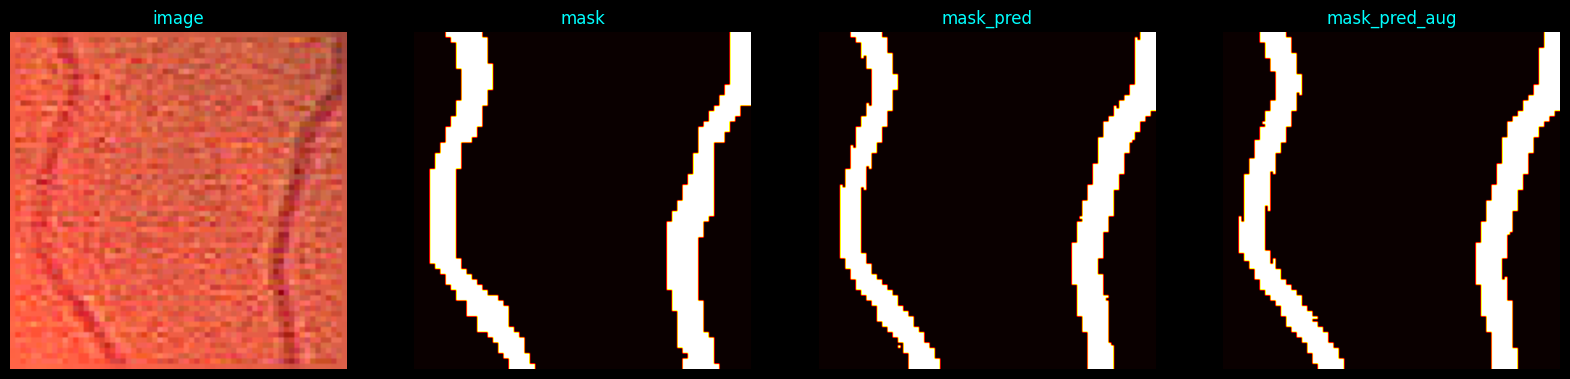

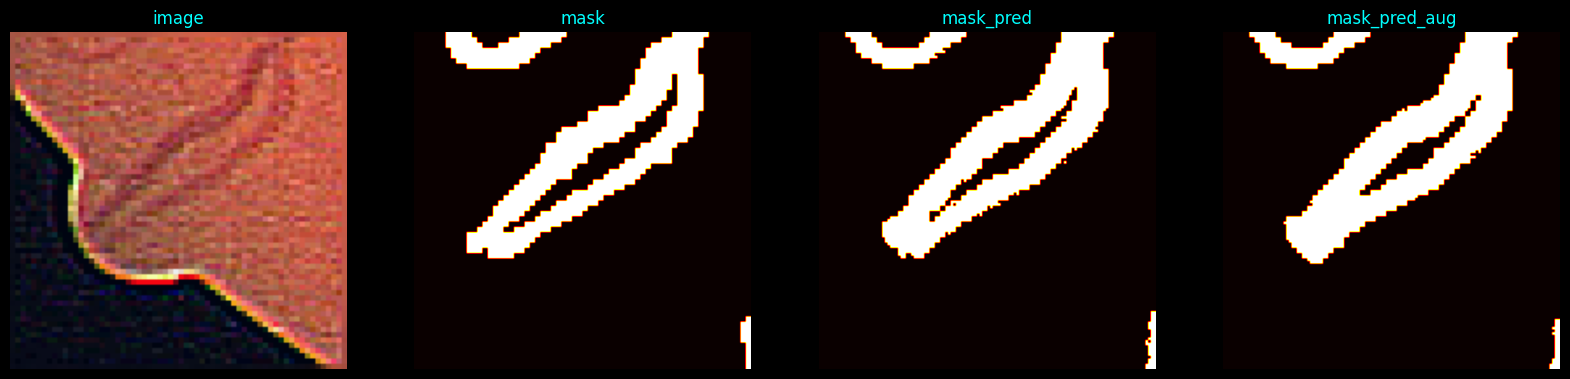

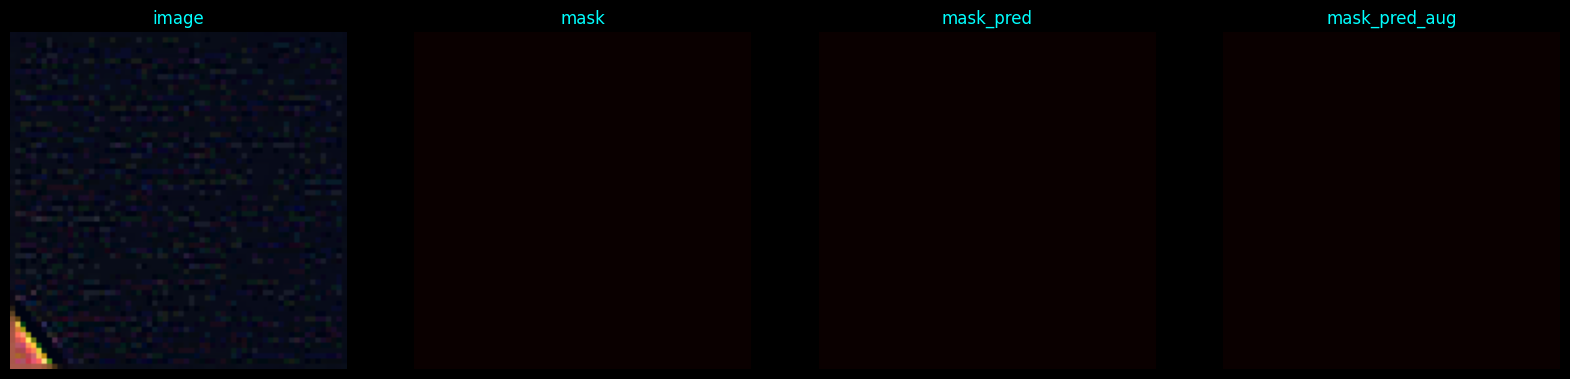

In [96]:
threshold = 0.5
num = 4
for image , mask in zip(images[:num] , masks[:num]):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
    mask_pred , mask_pred_aug = get_aug_image(image)
    
    mask_pred = (mask_pred>threshold)
    mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image ,mask,mask_pred,mask_pred_aug],['image','mask','mask_pred','mask_pred_aug'],size = 5,cmap='hot')

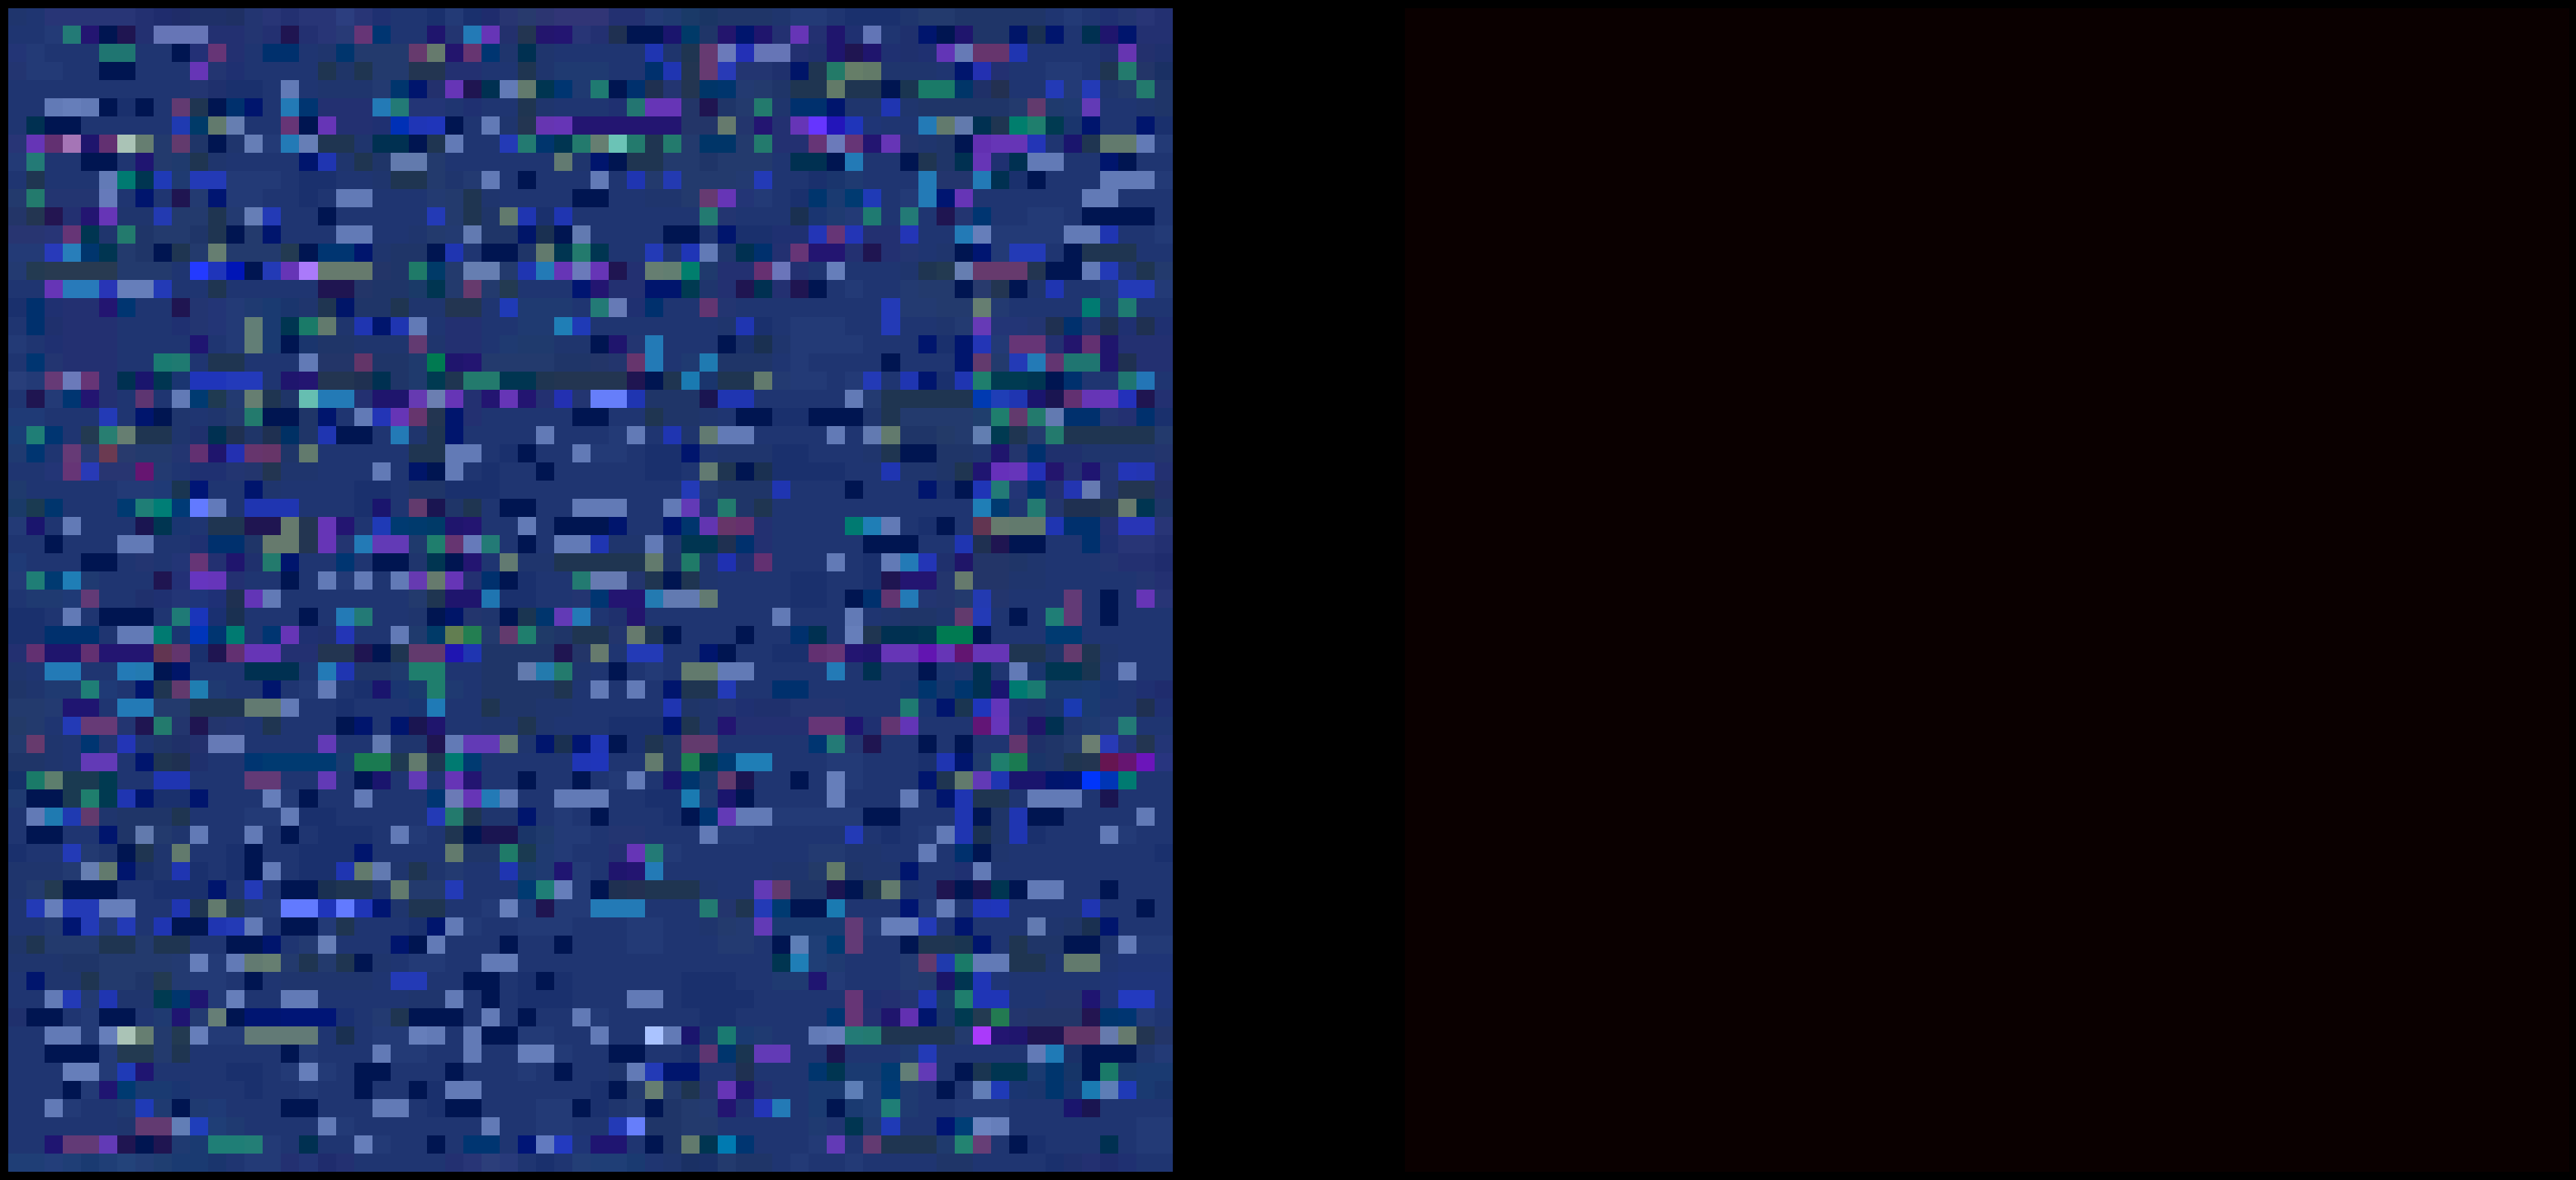

In [89]:
image = images[0]
image = (image-image.min()) / (image.max()-image.min()) 

display_images([image,masks[0]],size = 20,cmap='hot')

In [ ]:
# metric_List = list(History.keys())
# model_name = 'Unet'

# plt.figure(figsize = (16,4),facecolor='#301934').suptitle(model_name+" Performance",fontsize=16, y=1)
# for i,metric in enumerate(metric_List[:3],1):
#     plt.subplot(1,3,i)
#     plt.plot(History[metric],label='train',linewidth=2)
#     plt.plot(History['val_'+ metric],label='validation',linewidth=1.5)
#     plt.title(metric)
#     plt.legend()
#     plt.ylabel(metric + ' -->')
#     plt.xlabel('epoch -->')
#     plt.subplots_adjust(wspace=0.2, hspace=0.3) 
#     plt.grid()
# plt.show()

## Testing on Test Image

In [165]:
patch_size = (64,64)
step = 32
n_classes = 1

def get_aug_image2(image):
    image = np.array(image)
    
    if(image.shape[-1]==3):
        patches = patchify(image , patch_size + (3,) ,step = step)
        patches = np.squeeze(patches ,axis= 2)
    else:
        patches = patchify(image , patch_size ,step = step)

    patches_shape = patches.shape  
    
#     print(patches_shape)
    mask_patches = np.zeros( patches_shape[:4] + (n_classes ,) ,dtype = np.float32)
    mask_patches_aug = np.zeros( patches_shape[:4] + (n_classes ,) ,dtype = np.float32)

#     print(mask_patches.shape)
    
    for i in range(patches_shape[0]):
        for j in range(patches_shape[1]):
            image = patches[i][j]
            mask ,mask_aug = get_aug_image(image)   ## output will be 64,64,1
#             print(mask.shape)
            mask_patches[i][j] = np.maximum(mask_patches[i][j] , mask)
            mask_patches_aug[i][j] = np.maximum(mask_patches_aug[i][j] , mask_aug)

    
    mask_patches = np.expand_dims(mask_patches,axis=2) ## as we squeezed patches 
    mask_patches_aug = np.expand_dims(mask_patches_aug,axis=2) ## as we squeezed patches 

    mask_shape = image.shape[:2] + (n_classes,)
#     print(mask_shape , mask_patches.shape)
    mask = unpatchify(mask_patches , mask_shape,)
    mask_aug = unpatchify(mask_patches_aug , mask_shape,)
    return mask , mask_aug

In [167]:
images,masks = next(iter(test_generator))
images.shape ,masks.shape

((2, 512, 512, 3), (2, 512, 512, 1))

>>>>>>>>>>

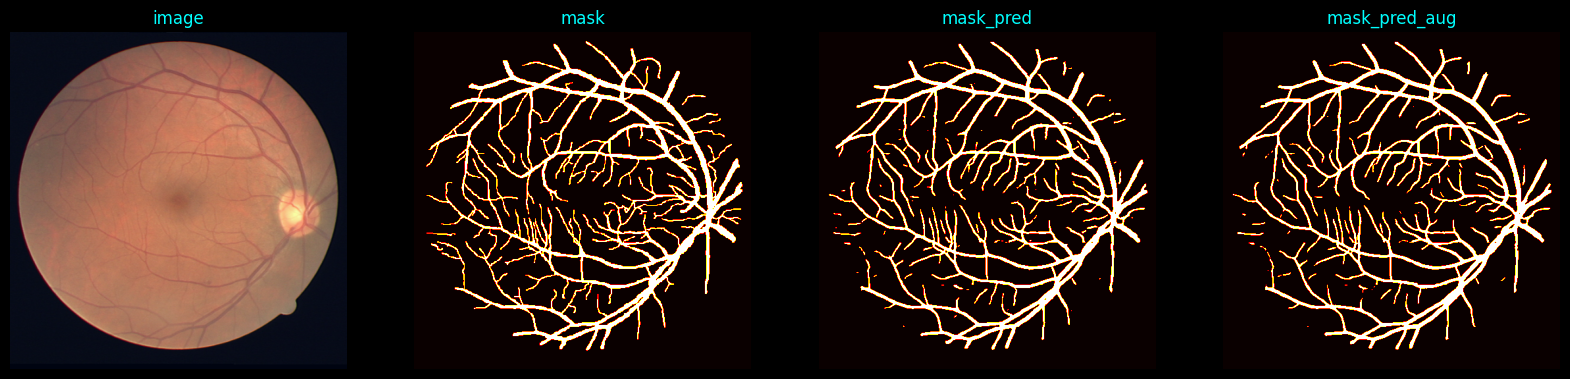

>>>>>>>>>>

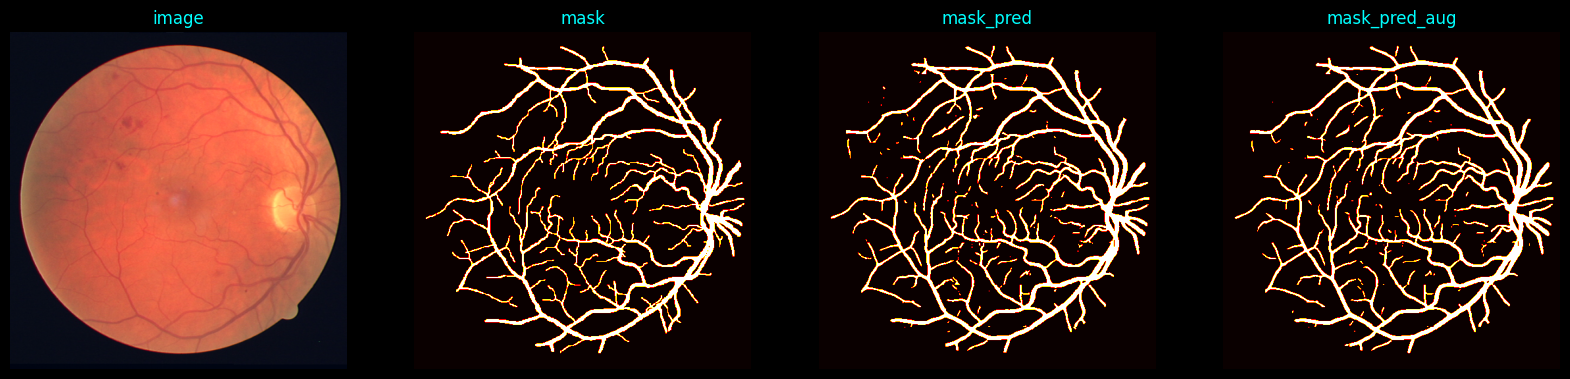

In [169]:
threshold = 0.5
num = 2
for image , mask in zip(images[:num] , masks[:num]):
    
#     print(image.min() ,image.max() , mask.min() ,mask.max())
    mask_pred , mask_pred_aug = get_aug_image2(image)
    
    mask_pred = (mask_pred>threshold)
    mask_pred_aug = (mask_pred_aug > threshold)
        
    image = (image-image.min()) / (image.max()-image.min()) 
    
    display_images([image ,mask,mask_pred,mask_pred_aug],['image','mask','mask_pred','mask_pred_aug'],size = 5,cmap='hot',grid = (2,2))